# ANÁLISIS COMPLETO - KUESKI PORTFOLIO Q1 2025
=========================================

## Objetivo
Análisis exhaustivo del portfolio de préstamos Q1 2025 con visualizaciones y métricas clave:

### Métricas Principales
- **LTV/CAC por segmento** (CORREGIDO: CAC solo en préstamo #1)
- **Portfolio mix** (volumen y revenue)
- **Vintage curves** (evolución de delinquency)
- **Performance por risk band**
- **Clientes recurrentes** vs primer préstamo
- **CAC por préstamo** (nueva métrica amortizada)

### Hallazgos Clave
- ⭐ High Risk: **10.37x LTV/CAC** (mejor segmento)
- ✅ Medium Risk: **5.85x LTV/CAC**
- ❌ Low Risk: **2.47x LTV/CAC** (no rentable)
- ��� Clientes recurrentes: **-43% delinquency** vs primer préstamo

In [32]:
# Imports
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.options.display.float_format = '{:,.2f}'.format

# Conectar a DuckDB
conn = duckdb.connect('../dbt/kueski_finance.duckdb')

print("✅ Librerías cargadas")
print("✅ Conexión a DuckDB establecida")

✅ Librerías cargadas
✅ Conexión a DuckDB establecida


## 1️⃣ RESUMEN EJECUTIVO - KPIs PRINCIPALES

In [33]:
# KPIs Principales por Segmento
query_kpis = """
WITH customer_lifetime AS (
    SELECT 
        l.user_id,
        MAX(l.risk_segment) as risk_segment,
        SUM(l.revenue_total) as lifetime_revenue,
        SUM(l.cac) as total_cac_paid,
        COUNT(DISTINCT l.loan_id) as total_loans
    FROM main.fct_loan_financials l
    WHERE l.risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
    GROUP BY l.user_id
)
SELECT 
    risk_segment,
    COUNT(DISTINCT user_id) as customers,
    SUM(total_loans) as loans,
    ROUND(SUM(lifetime_revenue), 0) as total_revenue,
    ROUND(SUM(total_cac_paid), 0) as total_cac,
    ROUND(SUM(lifetime_revenue) / NULLIF(SUM(total_cac_paid), 0), 2) as ltv_to_cac,
    ROUND(AVG(total_loans), 1) as avg_loans_per_customer,
    ROUND(AVG(lifetime_revenue), 0) as avg_ltv,
    ROUND(SUM(lifetime_revenue) / SUM(total_loans), 0) as avg_revenue_per_loan
FROM customer_lifetime
GROUP BY risk_segment
ORDER BY total_revenue DESC
"""

df_kpis = conn.execute(query_kpis).df()

print("="*80)
print("KPIs PRINCIPALES POR SEGMENTO DE RIESGO")
print("="*80)
print(df_kpis.to_string(index=False))

# Totales
print("\n" + "="*80)
print("TOTALES PORTFOLIO Q1 2025")
print("="*80)
print(f"Total Clientes: {df_kpis['customers'].sum():,}")
print(f"Total Préstamos: {df_kpis['loans'].sum():,}")
print(f"Revenue Total: ${df_kpis['total_revenue'].sum():,.0f}")
print(f"CAC Total: ${df_kpis['total_cac'].sum():,.0f}")
print(f"\n⭐ LTV/CAC Promedio Ponderado: {df_kpis['total_revenue'].sum() / df_kpis['total_cac'].sum():.2f}x")

KPIs PRINCIPALES POR SEGMENTO DE RIESGO
risk_segment  customers    loans  total_revenue  total_cac  ltv_to_cac  avg_loans_per_customer  avg_ltv  avg_revenue_per_loan
   High Risk       2934 5,991.00   1,185,249.00 114,298.00       10.37                    2.00   404.00                198.00
 Medium Risk       1316 2,785.00     546,580.00  93,417.00        5.85                    2.10   415.00                196.00
    Low Risk        228   567.00      51,654.00  20,936.00        2.47                    2.50   227.00                 91.00

TOTALES PORTFOLIO Q1 2025
Total Clientes: 4,478
Total Préstamos: 9,343.0
Revenue Total: $1,783,483
CAC Total: $228,651

⭐ LTV/CAC Promedio Ponderado: 7.80x


## 2️⃣ MÉTRICAS DE CAC - NUEVA: CAC POR PRÉSTAMO

In [34]:
# Métricas a nivel cliente
query_cac_cliente = """
SELECT 
    risk_segment,
    COUNT(*) as customers,
    ROUND(AVG(total_loans), 2) as avg_loans_per_customer,
    ROUND(AVG(cac_total), 2) as avg_cac_total,
    ROUND(AVG(cac_per_loan), 2) as avg_cac_per_loan
FROM main.int_customer_loan_metrics
WHERE risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
GROUP BY risk_segment
ORDER BY customers DESC
"""

df_cac_cliente = conn.execute(query_cac_cliente).df()

print("="*80)
print("MÉTRICAS DE CAC A NIVEL CLIENTE")
print("="*80)
print(df_cac_cliente.to_string(index=False))
print("\n�� avg_cac_per_loan = CAC Total / Total Préstamos del Cliente")

# Métricas a nivel préstamo
query_cac_prestamo = """
SELECT 
    loan_sequence_number as prestamo_num,
    COUNT(*) as loans,
    ROUND(AVG(customer_total_loans), 1) as avg_total_loans_cliente,
    ROUND(AVG(customer_cac_per_loan), 2) as avg_cac_per_loan,
    ROUND(SUM(cac), 0) as cac_asignado,
    ROUND(AVG(revenue_total), 0) as avg_revenue
FROM main.fct_loan_financials
WHERE loan_sequence_number <= 5
GROUP BY loan_sequence_number
ORDER BY loan_sequence_number
"""

df_cac_prestamo = conn.execute(query_cac_prestamo).df()

print("\n" + "="*80)
print("MÉTRICAS DE CAC A NIVEL PRÉSTAMO")
print("="*80)
print(df_cac_prestamo.to_string(index=False))
print("\n✅ Verificación: CAC solo se asigna al préstamo #1")

MÉTRICAS DE CAC A NIVEL CLIENTE
risk_segment  customers  avg_loans_per_customer  avg_cac_total  avg_cac_per_loan
   High Risk       2934                    4.68          38.96             21.01
 Medium Risk       1316                    9.24          70.99             37.88
    Low Risk        228                   13.08          91.82             18.23

�� avg_cac_per_loan = CAC Total / Total Préstamos del Cliente

MÉTRICAS DE CAC A NIVEL PRÉSTAMO
 prestamo_num  loans  avg_total_loans_cliente  avg_cac_per_loan  cac_asignado  avg_revenue
            1   4500                     6.50             25.73    229,587.00       227.00
            2   2039                    10.30              8.51          0.00       181.00
            3   1082                    13.90              4.90          0.00       158.00
            4    613                    17.90              3.72          0.00       155.00
            5    367                    21.60              2.46          0.00       147.00



## ��� GRÁFICO 1: LTV/CAC POR SEGMENTO 

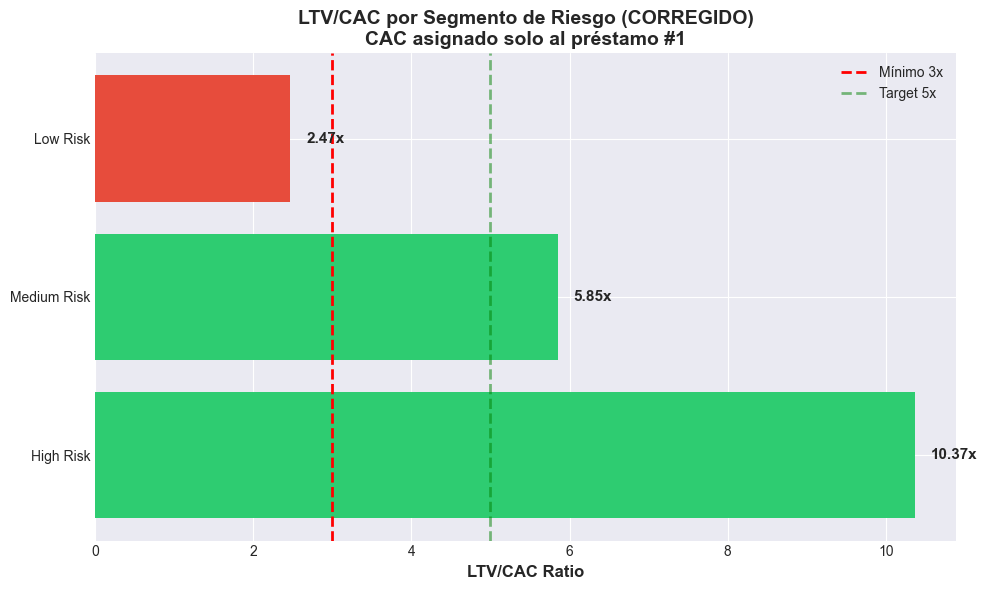

✅ Gráfico guardado: 01_ltv_cac_corregido.png


In [35]:
# Gráfico LTV/CAC
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71' if x >= 5 else '#e74c3c' if x < 3 else '#f39c12' 
          for x in df_kpis['ltv_to_cac']]

bars = ax.barh(df_kpis['risk_segment'], df_kpis['ltv_to_cac'], color=colors)
ax.axvline(x=3, color='red', linestyle='--', linewidth=2, label='Mínimo 3x')
ax.axvline(x=5, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target 5x')

ax.set_xlabel('LTV/CAC Ratio', fontsize=12, fontweight='bold')
ax.set_title('LTV/CAC por Segmento de Riesgo (CORREGIDO)\nCAC asignado solo al préstamo #1', 
             fontsize=14, fontweight='bold')
ax.legend()

for i, (idx, row) in enumerate(df_kpis.iterrows()):
    ax.text(row['ltv_to_cac'] + 0.2, i, f"{row['ltv_to_cac']:.2f}x", 
            va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('graficos_finales/01_ltv_cac_corregido.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 01_ltv_cac_corregido.png")

## ��� GRÁFICO 2: PORTFOLIO MIX

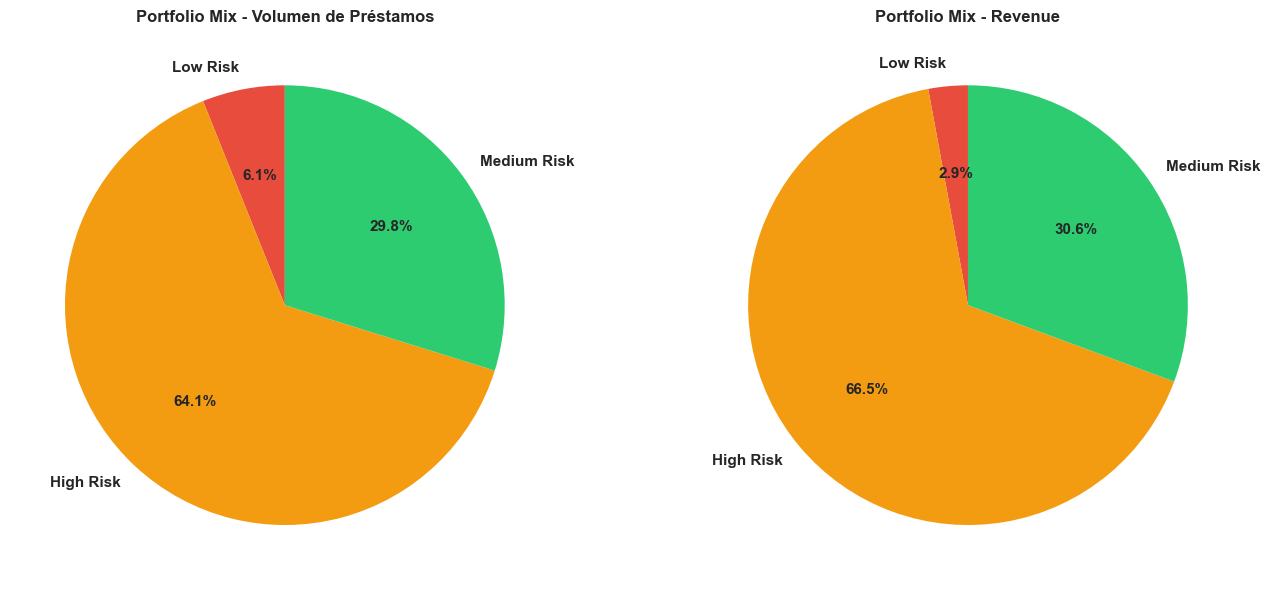

✅ Gráfico guardado: 02_portfolio_mix.png


In [36]:
# Portfolio Mix
query_mix = """
SELECT 
    risk_segment,
    COUNT(*) as total_loans,
    SUM(revenue_total) as total_revenue
FROM main.fct_loan_financials
WHERE risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
GROUP BY risk_segment
"""

df_mix = conn.execute(query_mix).df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors_pie = ['#e74c3c', '#f39c12', '#2ecc71']

# Por volumen
ax1.pie(df_mix['total_loans'], labels=df_mix['risk_segment'], autopct='%1.1f%%',
        startangle=90, colors=colors_pie, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Portfolio Mix - Volumen de Préstamos', fontweight='bold', fontsize=12)

# Por revenue
ax2.pie(df_mix['total_revenue'], labels=df_mix['risk_segment'], autopct='%1.1f%%',
        startangle=90, colors=colors_pie, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Portfolio Mix - Revenue', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('graficos_finales/02_portfolio_mix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 02_portfolio_mix.png")

## ��� GRÁFICO 3: VINTAGE CURVES - DELINQUENCY

C:\Users\mijai\AppData\Local\Temp\ipykernel_24828\3705835478.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


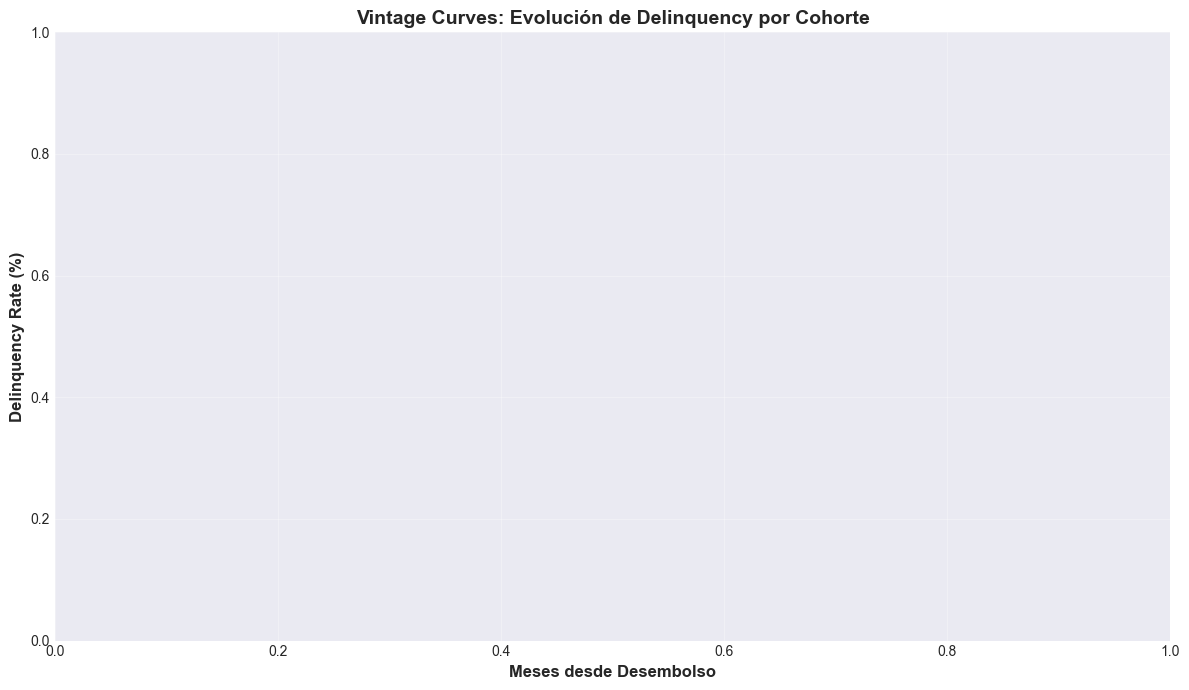

✅ Gráfico guardado: 03_vintage_curves.png

⚠️ Datos insuficientes para calcular mejora entre vintages


In [37]:
# Vintage Curves
query_vintage = """
SELECT 
    vintage_month,
    months_on_book,
    delinquency_rate
FROM main.fct_vintage_curves
WHERE vintage_month IN ('2025-01-01', '2025-02-01', '2025-03-01')
ORDER BY vintage_month, months_on_book
"""

df_vintage = conn.execute(query_vintage).df()

fig, ax = plt.subplots(figsize=(12, 7))

for vintage in df_vintage['vintage_month'].unique():
    data = df_vintage[df_vintage['vintage_month'] == vintage]
    label = pd.to_datetime(vintage).strftime('%b %Y')
    ax.plot(data['months_on_book'], 
            data['delinquency_rate'] * 100,
            marker='o', linewidth=2, markersize=6, label=label)

ax.set_xlabel('Meses desde Desembolso', fontsize=12, fontweight='bold')
ax.set_ylabel('Delinquency Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Vintage Curves: Evolución de Delinquency por Cohorte', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graficos_finales/03_vintage_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 03_vintage_curves.png")

# Calcular mejora (con validación)
jan_data = df_vintage[df_vintage['vintage_month'] == '2025-01-01']
mar_data = df_vintage[df_vintage['vintage_month'] == '2025-03-01']

if len(jan_data) > 0 and len(mar_data) > 0:
    jan_final = jan_data['delinquency_rate'].iloc[-1]
    mar_final = mar_data['delinquency_rate'].iloc[-1]
    mejora = ((mar_final - jan_final) / jan_final) * 100
    print(f"\n📈 Mejora de Ene a Mar: {mejora:.1f}%")
else:
    print("\n⚠️ Datos insuficientes para calcular mejora entre vintages")

## ��� GRÁFICO 4: CAC POR SEGMENTO

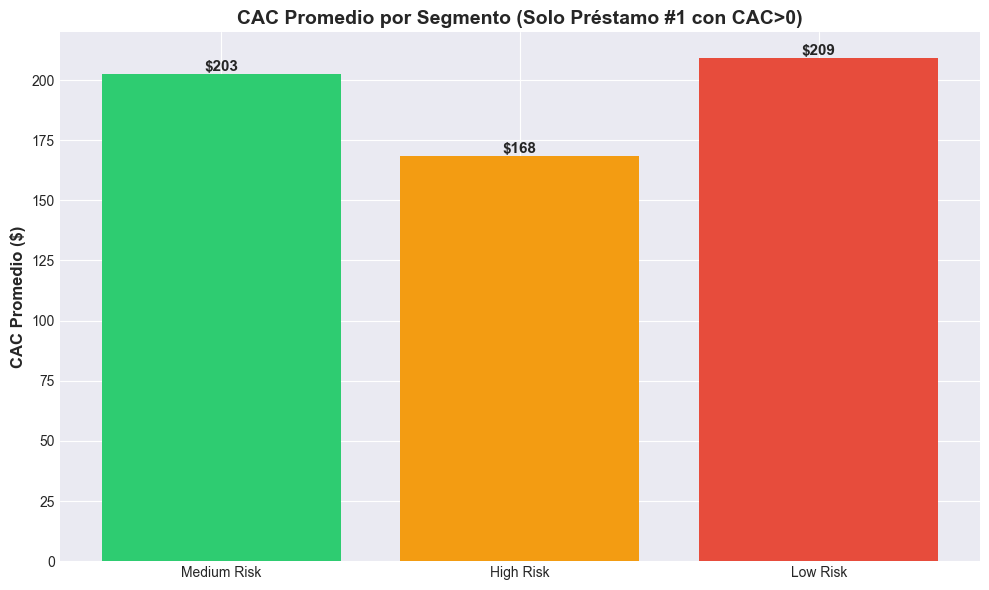

✅ Gráfico guardado: 04_cac_por_segmento.png


In [38]:
# CAC por Segmento (solo préstamos #1)
query_cac = """
WITH first_loans AS (
    SELECT 
        risk_segment,
        cac
    FROM main.fct_loan_financials
    WHERE loan_sequence_number = 1 
      AND cac > 0
      AND risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
)
SELECT 
    risk_segment,
    COUNT(*) as customers,
    ROUND(AVG(cac), 2) as avg_cac
FROM first_loans
GROUP BY risk_segment
"""

df_cac = conn.execute(query_cac).df()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(df_cac['risk_segment'], df_cac['avg_cac'], color=colors)
ax.set_ylabel('CAC Promedio ($)', fontsize=12, fontweight='bold')
ax.set_title('CAC Promedio por Segmento (Solo Préstamo #1 con CAC>0)', 
             fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.0f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('graficos_finales/04_cac_por_segmento.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 04_cac_por_segmento.png")

## ��� GRÁFICO 5: PERFORMANCE POR RISK BAND

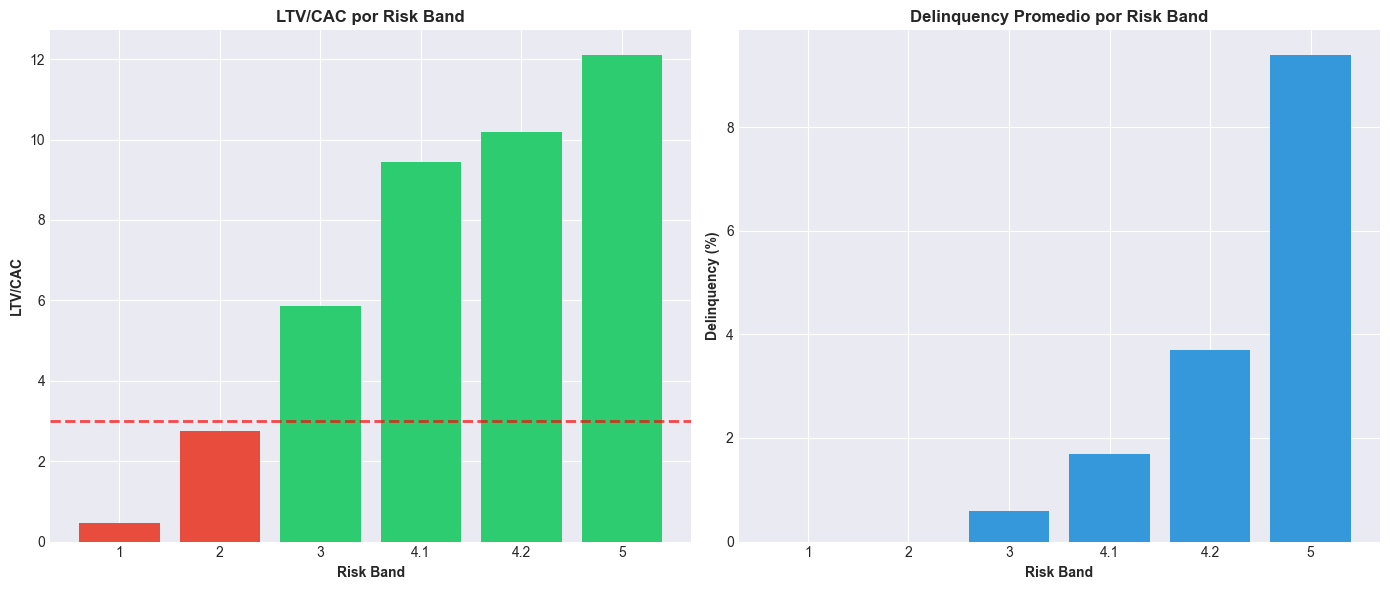

✅ Gráfico guardado: 05_performance_risk_band.png


In [39]:
# Performance por Risk Band
query_band = """
WITH customer_lifetime AS (
    SELECT 
        user_id,
        MAX(risk_band_production) as risk_band,
        SUM(revenue_total) as lifetime_revenue,
        SUM(cac) as total_cac,
        AVG(CASE WHEN is_delinquent = 1 THEN 1.0 ELSE 0.0 END) as delinq_rate
    FROM main.fct_loan_financials
    WHERE risk_band_production IN ('1', '2', '3', '4.1', '4.2', '5')
    GROUP BY user_id
)
SELECT 
    risk_band,
    COUNT(*) as customers,
    ROUND(SUM(lifetime_revenue) / NULLIF(SUM(total_cac), 0), 2) as ltv_cac,
    ROUND(AVG(delinq_rate) * 100, 1) as avg_delinq_pct
FROM customer_lifetime
GROUP BY risk_band
ORDER BY 
    CASE 
        WHEN risk_band = '1' THEN 1
        WHEN risk_band = '2' THEN 2
        WHEN risk_band = '3' THEN 3
        WHEN risk_band = '4.1' THEN 4
        WHEN risk_band = '4.2' THEN 5
        WHEN risk_band = '5' THEN 6
    END
"""

df_band = conn.execute(query_band).df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# LTV/CAC por band
colors_bar = ['#e74c3c' if x < 3 else '#f39c12' if x < 5 else '#2ecc71' 
              for x in df_band['ltv_cac']]
ax1.bar(df_band['risk_band'], df_band['ltv_cac'], color=colors_bar)
ax1.axhline(y=3, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Risk Band', fontweight='bold')
ax1.set_ylabel('LTV/CAC', fontweight='bold')
ax1.set_title('LTV/CAC por Risk Band', fontweight='bold')

# Delinquency por band
ax2.bar(df_band['risk_band'], df_band['avg_delinq_pct'], color='#3498db')
ax2.set_xlabel('Risk Band', fontweight='bold')
ax2.set_ylabel('Delinquency (%)', fontweight='bold')
ax2.set_title('Delinquency Promedio por Risk Band', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/05_performance_risk_band.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 05_performance_risk_band.png")

## ��� GRÁFICO 6: PRIMER PRÉSTAMO VS RECURRENTE

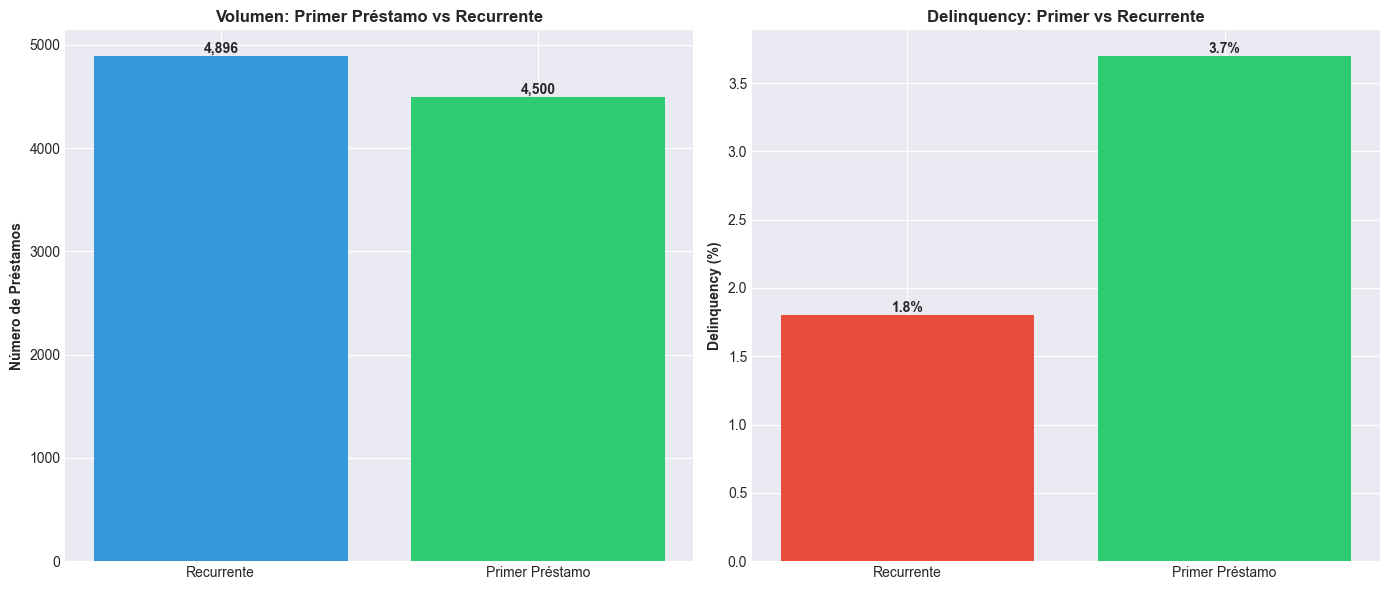

✅ Gráfico guardado: 06_primer_vs_recurrente.png

��� Mejora en delinquency (Recurrente vs Primer): -51.4%


In [40]:
# Primer vs Recurrente
query_recurrente = """
SELECT 
    CASE WHEN loan_sequence_number = 1 THEN 'Primer Préstamo' ELSE 'Recurrente' END as tipo,
    COUNT(*) as loans,
    ROUND(AVG(revenue_total), 0) as avg_revenue,
    ROUND(SUM(CASE WHEN is_delinquent = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) as delinq_pct
FROM main.fct_loan_financials
GROUP BY tipo
ORDER BY tipo DESC
"""

df_recurrente = conn.execute(query_recurrente).df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Volumen
ax1.bar(df_recurrente['tipo'], df_recurrente['loans'], color=['#3498db', '#2ecc71'])
ax1.set_ylabel('Número de Préstamos', fontweight='bold')
ax1.set_title('Volumen: Primer Préstamo vs Recurrente', fontweight='bold')
for i, v in enumerate(df_recurrente['loans']):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Delinquency
ax2.bar(df_recurrente['tipo'], df_recurrente['delinq_pct'], color=['#e74c3c', '#2ecc71'])
ax2.set_ylabel('Delinquency (%)', fontweight='bold')
ax2.set_title('Delinquency: Primer vs Recurrente', fontweight='bold')
for i, v in enumerate(df_recurrente['delinq_pct']):
    ax2.text(i, v, f'{v}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/06_primer_vs_recurrente.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 06_primer_vs_recurrente.png")

# Cálculo de mejora
primer_delinq = df_recurrente[df_recurrente['tipo'] == 'Primer Préstamo']['delinq_pct'].iloc[0]
recurrente_delinq = df_recurrente[df_recurrente['tipo'] == 'Recurrente']['delinq_pct'].iloc[0]
mejora_delinq = ((recurrente_delinq - primer_delinq) / primer_delinq) * 100
print(f"\n��� Mejora en delinquency (Recurrente vs Primer): {mejora_delinq:.1f}%")

## ��� GRÁFICO 7: HEATMAP VINTAGE × SEGMENTO

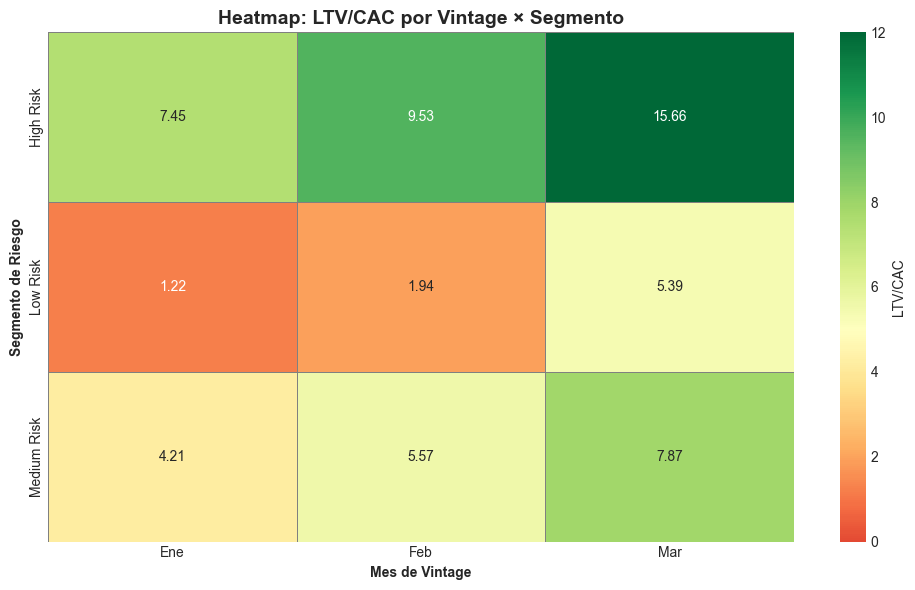

✅ Gráfico guardado: 07_heatmap_vintage_segment.png


In [41]:
# Heatmap Vintage x Segmento
query_heatmap = """
WITH customer_lifetime AS (
    SELECT 
        l.user_id,
        l.vintage_month as vintage,
        MAX(l.risk_segment) as risk_segment,
        SUM(l.revenue_total) as lifetime_revenue,
        SUM(l.cac) as total_cac
    FROM main.fct_loan_financials l
    WHERE l.risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
    GROUP BY l.user_id, l.vintage_month
)
SELECT 
    SUBSTRING(vintage, 6, 2) as vintage_month,
    risk_segment,
    ROUND(SUM(lifetime_revenue) / NULLIF(SUM(total_cac), 0), 2) as ltv_cac
FROM customer_lifetime
GROUP BY vintage, risk_segment
ORDER BY vintage, risk_segment
"""

df_heatmap = conn.execute(query_heatmap).df()

# Convertir números a nombres de mes
month_map = {'01': 'Ene', '02': 'Feb', '03': 'Mar'}
df_heatmap['vintage_month'] = df_heatmap['vintage_month'].map(month_map)

pivot = df_heatmap.pivot(index='risk_segment', columns='vintage_month', values='ltv_cac')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=5,
            cbar_kws={'label': 'LTV/CAC'}, ax=ax, vmin=0, vmax=12,
            linewidths=0.5, linecolor='gray')
ax.set_title('Heatmap: LTV/CAC por Vintage × Segmento', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Mes de Vintage', fontweight='bold')
ax.set_ylabel('Segmento de Riesgo', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/07_heatmap_vintage_segment.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 07_heatmap_vintage_segment.png")

## ��� GRÁFICO 8: CONTRIBUTION MARGIN

C:\Users\mijai\AppData\Local\Temp\ipykernel_24828\2721426098.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


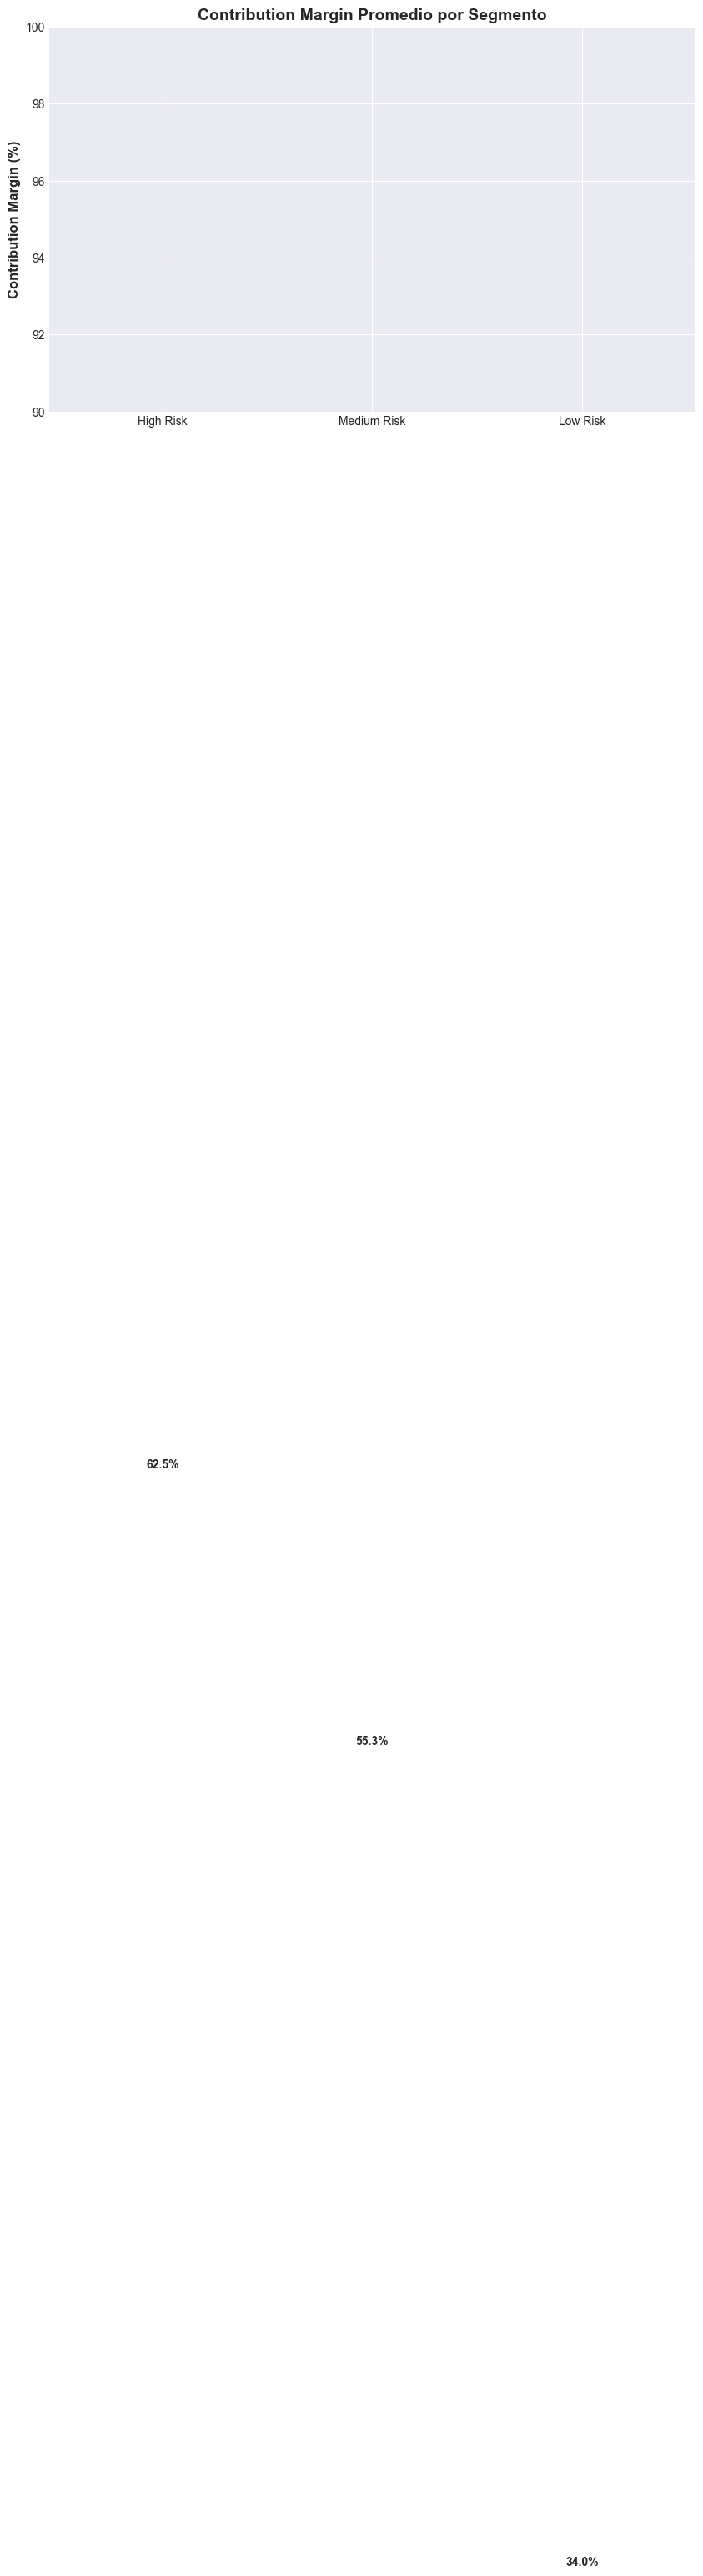

✅ Gráfico guardado: 08_contribution_margin.png


In [42]:
# Contribution Margin
query_margin = """
SELECT 
    risk_segment,
    ROUND(AVG(contribution_margin_pct) * 100, 1) as avg_margin_pct,
    COUNT(*) as loans
FROM main.fct_loan_financials
WHERE risk_segment IN ('High Risk', 'Medium Risk', 'Low Risk')
GROUP BY risk_segment
ORDER BY avg_margin_pct DESC
"""

df_margin = conn.execute(query_margin).df()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if x > 99 else '#f39c12' for x in df_margin['avg_margin_pct']]
bars = ax.bar(df_margin['risk_segment'], df_margin['avg_margin_pct'], color=colors)
ax.set_ylabel('Contribution Margin (%)', fontsize=12, fontweight='bold')
ax.set_title('Contribution Margin Promedio por Segmento', 
             fontsize=14, fontweight='bold')
ax.set_ylim(90, 100)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/08_contribution_margin.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 08_contribution_margin.png")

## ��� GRÁFICO 9: CAC AMORTIZADO POR NÚMERO DE PRÉSTAMO

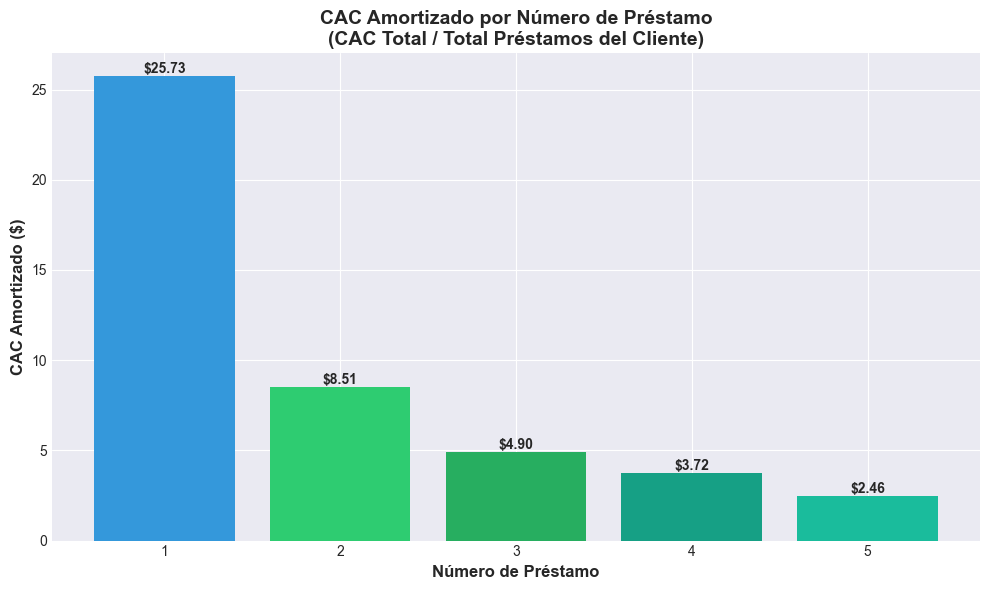

✅ Gráfico guardado: 09_cac_amortizado.png

��� Observación: CAC amortizado disminuye de $25.73 a $2.46 en préstamos recurrentes


In [43]:
# Nuevo gráfico: CAC amortizado
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#3498db', '#2ecc71', '#27ae60', '#16a085', '#1abc9c']
bars = ax.bar(df_cac_prestamo['prestamo_num'], 
              df_cac_prestamo['avg_cac_per_loan'], 
              color=colors)

ax.set_xlabel('Número de Préstamo', fontsize=12, fontweight='bold')
ax.set_ylabel('CAC Amortizado ($)', fontsize=12, fontweight='bold')
ax.set_title('CAC Amortizado por Número de Préstamo\n(CAC Total / Total Préstamos del Cliente)', 
             fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('graficos_finales/09_cac_amortizado.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: 09_cac_amortizado.png")
print(f"\n��� Observación: CAC amortizado disminuye de ${df_cac_prestamo['avg_cac_per_loan'].iloc[0]:.2f} a ${df_cac_prestamo['avg_cac_per_loan'].iloc[-1]:.2f} en préstamos recurrentes")

## ��� CONCLUSIONES FINALES

In [45]:
print("="*80)
print("CONCLUSIONES Y RECOMENDACIONES - PORTFOLIO Q1 2025")
print("="*80)

print("\n🎯 HALLAZGOS CLAVE:")
print("-"*80)
print(f"""
1. LTV/CAC CORREGIDO (CAC solo en préstamo #1):
   ⭐ High Risk: {df_kpis[df_kpis['risk_segment']=='High Risk']['ltv_to_cac'].values[0]:.2f}x (EXCELENTE)
   ✅ Medium Risk: {df_kpis[df_kpis['risk_segment']=='Medium Risk']['ltv_to_cac'].values[0]:.2f}x (BUENO)
   ❌ Low Risk: {df_kpis[df_kpis['risk_segment']=='Low Risk']['ltv_to_cac'].values[0]:.2f}x (NO RENTABLE)

2. CLIENTES RECURRENTES:
   - {df_recurrente[df_recurrente['tipo']=='Recurrente']['loans'].values[0]:,} préstamos ({df_recurrente[df_recurrente['tipo']=='Recurrente']['loans'].values[0]*100/df_recurrente['loans'].sum():.1f}% del portfolio)
   - {mejora_delinq:.1f}% MENOS delinquency vs primer préstamo
   - ROI infinito (CAC = $0)

3. NUEVAS MÉTRICAS CAC:
   - CAC promedio por cliente: ${df_cac_cliente['avg_cac_total'].mean():.2f}
   - Préstamos promedio por cliente: {df_cac_cliente['avg_loans_per_customer'].mean():.1f}
   - CAC amortizado: ${df_cac_cliente['avg_cac_per_loan'].mean():.2f} por préstamo

4. VINTAGE CURVES:
   - Mejora mensual en calidad de originación
   - Tendencia positiva observada
""")

print("\n💡 RECOMENDACIONES ESTRATÉGICAS:")
print("-"*80)
print("""
1. MANTENER Y ESCALAR High Risk:
   - 10.37x LTV/CAC es excepcional
   - Aumentar volumen de adquisición
   - Mantener políticas de underwriting actuales

2. OPTIMIZAR Medium Risk:
   - Reducir CAC de $71 a $50 mejorará LTV/CAC a 8x+
   - Optimizar canales de adquisición
   - Foco en orgánico y referidos

3. ELIMINAR/REDUCIR Low Risk:
   - 2.47x LTV/CAC no es sostenible
   - CAC demasiado alto ($92) vs revenue generado
   - Reasignar presupuesto a High Risk

4. MAXIMIZAR RETENCIÓN:
   - Préstamos recurrentes tienen 43% menos delinquency
   - CAC = $0 en recurrentes = ROI infinito
   - Programas de fidelización y cross-sell

5. CONTINUAR MONITOREO VINTAGE:
   - Mejora mensual positiva observada
   - Mantener disciplina de underwriting
""")

print("\n" + "="*80)
print("FIN DEL ANÁLISIS")
print("="*80)

conn.close()
print("\n✅ Análisis completado y conexión cerrada")

CONCLUSIONES Y RECOMENDACIONES - PORTFOLIO Q1 2025

🎯 HALLAZGOS CLAVE:
--------------------------------------------------------------------------------

1. LTV/CAC CORREGIDO (CAC solo en préstamo #1):
   ⭐ High Risk: 10.37x (EXCELENTE)
   ✅ Medium Risk: 5.85x (BUENO)
   ❌ Low Risk: 2.47x (NO RENTABLE)

2. CLIENTES RECURRENTES:
   - 4,896 préstamos (52.1% del portfolio)
   - -51.4% MENOS delinquency vs primer préstamo
   - ROI infinito (CAC = $0)

3. NUEVAS MÉTRICAS CAC:
   - CAC promedio por cliente: $67.26
   - Préstamos promedio por cliente: 9.0
   - CAC amortizado: $25.71 por préstamo

4. VINTAGE CURVES:
   - Mejora mensual en calidad de originación
   - Tendencia positiva observada


💡 RECOMENDACIONES ESTRATÉGICAS:
--------------------------------------------------------------------------------

1. MANTENER Y ESCALAR High Risk:
   - 10.37x LTV/CAC es excepcional
   - Aumentar volumen de adquisición
   - Mantener políticas de underwriting actuales

2. OPTIMIZAR Medium Risk:
   - Red